# <center> Machine Learning for Marketing Project: Marketing Campaign 

## Project 2 - Regression 
### Predict total bikes that will be rented per day
#### This notebook uses the *bike_day_v2.xlsx*

## Dataset description

| Column Name | Description                                                                                                                           |
|-------------|---------------------------------------------------------------------------------------------------------------------------------------|
| instant     | record index                                                                                                                          |
| dteday      | date                                                                                                                                  |
| season      | season (1:spring, 2:summer, 3:fall, 4:winter)                                                                                        |
| yr          | year (0: 2011, 1:2012)                                                                                                               |
| mnth        | month (1 to 12)                                                                                                                       |
| holiday     | weather day is holiday or not (extracted from [holiday schedule](http://dchr.dc.gov/page/holiday-schedule))                          |
| weekday     | day of the week                                                                                                                       |
| workingday  | if day is neither weekend nor holiday is 1, otherwise is 0                                                                           |
| schoolday   | if day is a normal school day is 1, otherwise is 0                                                                                   |
| weathersit  | 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| temp        | Normalized temperature in Celsius. The values are divided to 41 (max)                                                                 |
| atemp       | Normalized feeling temperature in Celsius. The values are divided to 50 (max)                                                        |
| hum         | Normalized humidity. The values are divided to 100 (max)                                                                              |
| windspeed   | Normalized wind speed. The values are divided to 67 (max)                                                                             |
| casual      | count of casual users                                                                                                                 |
| registered  | count of registered users                                                                                                             |
| cnt         | count of total rental bikes including both casual and registered                                                                      |

## **1. BUSINESS UNDERSTANDING**

### **Overview**
<p>The customer whishes to build a model to predict everyday at 15h00 the total number of bikes they will rent the following day. This will allow them not only to better allocate staff resources, but also to define their daily marketing budget in social media which is their principal form of advertisement.</p>

### Model building

<p>To achieve the objective, it is followed a systematic approach, CRISP-DM, that involves several stages. It is started by preparing the data, cleaning, and organizing it for analysis. Next, perform exploratory data analysis (EDA) to gain insights into the dataset and identify any patterns or trends. Once I have a thorough understanding of the data, it is proceed to train and evaluate predictive models using 4 different machine learning techniques with their best parameters such as: <p>

- Random Forest Regressor
- XGBoost 
- GradientBoosting 
- Lasso Regression

I tried to explore various models from different families, including bagging techniques like RandomForestRegressor, boosting methods such as XGBoost and GradientBoosting, as well as Lasso Regression.

### Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import re
import math
import calendar
import graphviz
import warnings
from tabulate import tabulate
import time
import optuna
import pickle

# Machine Learning Libraries
from sklearn import tree
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, max_error, make_scorer
from yellowbrick.model_selection import RFECV, LearningCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
import xgboost as xgb

# Set random state and cross-validation folds
random_state = 2024
n_splits = 10
cv = 10

# Warnings handling
warnings.filterwarnings("ignore")

# Set seaborn style
sns.set_style("whitegrid")

#### **Helper functions**

In [2]:
# Function to visualize the learning curve of a machine learning model using 10-fold-cross-validation
def plot_learning_curve(X, y, estimator, train_sizes=np.linspace(0.1, 1.0, 5), scoring='r2', n_jobs=4, random_state=random_state):
    """
    Plot learning curve to visualize the effect of training size on model performance.

    Parameters:
        X (array-like): The input samples.
        y (array-like): The target values.
        estimator: The machine learning model to evaluate.
        train_sizes (array-like, optional): The training sizes to use for plotting the learning curve.
            Default is np.linspace(0.1, 1.0, 5).
        scoring (str, callable, list, tuple, or dict, optional): The scoring strategy to evaluate the model.
            Default is 'r2' for coefficient of determination.
        n_jobs (int, optional): Number of jobs to run in parallel for computation. Default is 4.
        random_state (int or None, optional): Random state for reproducibility. Default is 2024.
    """
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

    visualizer = LearningCurve(
        estimator=estimator,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=n_jobs,
        random_state=random_state
    )

    visualizer.fit(X, y)
    visualizer.show()

In [3]:
# Function to evaluate the performance of the models on both training and testing datasets
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a machine learning model using various metrics.

    Parameters:
        model: The trained machine learning model.
        X_train (array-like): The feature matrix of the training set.
        y_train (array-like): The target values of the training set.
        X_test (array-like): The feature matrix of the test set.
        y_test (array-like): The target values of the test set.

    Returns:
        None

    Metrics used:
        - Execution Time
        - MAE (Mean Absolute Error)
        - RMSE (Root Mean Squared Error)
        - R^2 (R-squared)
        - Adjusted R^2
        - MAPE (Mean Absolute Percentage Error)
        - Max Error

    Example:
        evaluate_model(model, X_train, y_train, X_test, y_test)
    """
    start_time = time.time()

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    end_time = time.time()
    execution_time = end_time - start_time

    n_train_samples, n_train_features = X_train.shape
    n_test_samples, n_test_features = X_test.shape

    # Calculate evaluation metrics for train set
    train_mae = mean_absolute_error(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_r_squared = r2_score(y_train, train_pred)
    train_adjusted_r_squared = 1 - (1 - train_r_squared) * (n_train_samples - 1) / (n_train_samples - n_train_features - 1)
    train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
    train_max_err = max_error(y_train, train_pred)

    # Calculate evaluation metrics for test set
    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r_squared = r2_score(y_test, test_pred)
    test_adjusted_r_squared = 1 - (1 - test_r_squared) * (n_test_samples - 1) / (n_test_samples - n_test_features - 1)
    test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
    test_max_err = max_error(y_test, test_pred)

    # Print the results directly
    headers = ["Metric", "Train Score", "Test Score"]
    print(tabulate([
        ["Execution Time (s)", execution_time, execution_time],
        ["MAE", train_mae, test_mae],
        ["RMSE", train_rmse, test_rmse],
        ["R^2", train_r_squared, test_r_squared],
        ["Adjusted R^2", train_adjusted_r_squared, test_adjusted_r_squared],
        ["MAPE", train_mape, test_mape],
        ["Max Error", train_max_err, test_max_err]
    ], headers=headers, floatfmt=".4f", tablefmt="grid"))

In [4]:
# Function to visualize residuals
def visualize_residuals(model, X_train, y_train, X_test, y_test):
    """
    Visualize the residuals of a machine learning model.

    Parameters:
        model: The trained machine learning model.
        X_train (array-like): The feature matrix of the training set.
        y_train (array-like): The target values of the training set.
        X_test (array-like): The feature matrix of the test set.
        y_test (array-like): The target values of the test set.

    Returns:
        None

    Example:
        visualize_residuals(model, X_train, y_train, X_test, y_test)
    """
    # Initialize ResidualsPlot object
    residuals_vis = ResidualsPlot(model)

    # Fit the training data to the visualizer
    residuals_vis.fit(X_train, y_train)

    # Evaluate the model on the test data
    residuals_vis.score(X_test, y_test)

    # Display the plot
    residuals_vis.show()

In [5]:
# Function to visualize prediction error
def visualize_prediction_error(model, X_train, y_train, X_test, y_test):
    """
    Visualize the prediction errors of a machine learning model.

    Parameters:
        model: The trained machine learning model.
        X_train (array-like): The feature matrix of the training set.
        y_train (array-like): The target values of the training set.
        X_test (array-like): The feature matrix of the test set.
        y_test (array-like): The target values of the test set.

    Returns:
        None

    Example:
        visualize_prediction_error(model, X_train, y_train, X_test, y_test)
    """
    # Initialize PredictionError object
    predError_vis = PredictionError(model)

    # Fit the training data to the visualizer
    predError_vis.fit(X_train, y_train)

    # Evaluate the model on the test data
    predError_vis.score(X_test, y_test)

    # Display the plot
    predError_vis.show()

#### **Loading the data**

In [6]:
# Load the excel file
ds = pd.read_excel('bike_day_v2.xlsx', engine='openpyxl')

In [7]:
# View top 5 rows
ds.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,schoolday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6.0,0,0.0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0.0,0,0.0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1.0,1,1.0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2.0,1,1.0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3.0,1,1.0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
# Check number of entries and data types for columns
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     732 non-null    int64         
 1   dteday      732 non-null    datetime64[ns]
 2   season      732 non-null    int64         
 3   yr          732 non-null    int64         
 4   mnth        732 non-null    int64         
 5   holiday     732 non-null    int64         
 6   weekday     730 non-null    float64       
 7   workingday  732 non-null    int64         
 8   schoolday   454 non-null    float64       
 9   weathersit  732 non-null    int64         
 10  temp        732 non-null    float64       
 11  atemp       732 non-null    float64       
 12  hum         732 non-null    float64       
 13  windspeed   732 non-null    float64       
 14  casual      732 non-null    int64         
 15  registered  732 non-null    int64         
 16  cnt         732 non-null  

- The dataset has 732 rows, 16 features and 1 target(cnt) column.
- Column names does not seem interpretable. It will be renamed and replaced with corresponding names.
- Since the 'instant' column is an index, it will be dropped.
- There are missing values in 'weekday' and 'schoolday' columns. The importance, reason and percentage of missing values will be discussed for the future actions.
- Data type of the columns look reasonable.
- 'dteday' column will be dropped because the dataset has year(yr), month(mnth) and the weekday column. Also it is not preferable and interpretable to use raw date column in modeling.
- The 'feeling_temperature' column is likely to be highly correlated with the 'temperature' column. Similarly, there might be a high correlation between the 'holiday' and 'workingday' columns.
- Since we are interested in predicting total rental counts (cnt) and not differentiating between casual and registered users, and also 'total_rental' column is the sum of the 'casual' and 'registered' users, I will exclude 'casual' and 'registered' columns.

It will be evaluated whether the statistics align with our initial observations and then decide whether to drop them accordingly.

#### **Rename the columns**

In [9]:
ds.rename(columns={'dteday': 'date',
                   'yr': 'year',
                   'mnth': 'month',
                   'weathersit': 'weather_condition',
                   'temp': 'temperature',
                   'atemp': 'feeling_temperature',
                   'hum': 'humidity',
                   'cnt': 'total_rental'}, inplace=True)
print(ds.columns)

Index(['instant', 'date', 'season', 'year', 'month', 'holiday', 'weekday',
       'workingday', 'schoolday', 'weather_condition', 'temperature',
       'feeling_temperature', 'humidity', 'windspeed', 'casual', 'registered',
       'total_rental'],
      dtype='object')


#### **Replace numerical values with corresponding names**

In [10]:
ds.season.replace({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"}, inplace=True)

ds.year.replace({0: 2011, 1:2012},inplace=True)

ds.month.replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
                  5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                  9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}, inplace=True)

ds.holiday.replace({0: 'no', 1: 'yes' }, inplace=True)

ds.weekday.replace({0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}, inplace=True)

ds.workingday.replace({0: 'no', 1: 'yes' }, inplace=True)

ds.schoolday.replace({0: 'no', 1: 'yes' }, inplace=True)

ds.weather_condition.replace({1: 'Clear & Few clouds', 2: 'Mist & Cloudy' , 3: 'Light snow & Rain', 4: 'Heavy Rain & Snow'}, inplace=True)

print(ds.season.unique())
print(ds.year.unique())
print(ds.month.unique())
print(ds.holiday.unique())
print(ds.weekday.unique())
print(ds.workingday.unique())
print(ds.schoolday.unique())
print(ds.weather_condition.unique())

['Spring' 'Summer' 'Fall' 'Winter']
[2011 2012]
['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec']
['no' 'yes']
['Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday'
 nan]
['no' 'yes']
['no' 'yes' nan]
['Mist & Cloudy' 'Clear & Few clouds' 'Light snow & Rain']


Name of the columns and values are renamed and replaced correctly. We move on!  

#### **Extract the day from 'date' column**

In [11]:
# Extract the day and create a new column
ds['day'] = ds['date'].dt.day

# Replacing the index for 'day' column
ds.insert(5, 'day', ds.pop('day'))

Day in the 'date' is extracted to see where it is a good feature.

In [12]:
# Quick view for renamed values and 'day' column
ds.head()

,instant,date,season,year,month,day,holiday,weekday,workingday,schoolday,weather_condition,temperature,feeling_temperature,humidity,windspeed,casual,registered,total_rental
0,1,2011-01-01,Spring,2011,Jan,1,no,Saturday,no,no,Mist & Cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,Spring,2011,Jan,2,no,Sunday,no,no,Mist & Cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,Spring,2011,Jan,3,no,Monday,yes,yes,Clear & Few clouds,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,Spring,2011,Jan,4,no,Tuesday,yes,yes,Clear & Few clouds,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,Spring,2011,Jan,5,no,Wednesday,yes,yes,Clear & Few clouds,0.226957,0.229270,0.436957,0.186900,82,1518,1600


#### **Reformat the data types**

In [13]:
# Convert categorical columns to categorical data type
categorical_cols = ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'schoolday', 'weather_condition']
for col in categorical_cols:
    ds[col] = ds[col].astype('category')

print(ds.dtypes)

instant                         int64
date                   datetime64[ns]
season                       category
year                         category
month                        category
day                             int32
holiday                      category
weekday                      category
workingday                   category
schoolday                    category
weather_condition            category
temperature                   float64
feeling_temperature           float64
humidity                      float64
windspeed                     float64
casual                          int64
registered                      int64
total_rental                    int64
dtype: object


Columns are converted into correct dtypes successfully.

## **2. DATA UNDERSTANDING**

#### **Summary statistics**

In [14]:
ds.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
instant,732.0,NaN,NaN,NaN,366.352459,1.0,183.75,366.5,549.25,731.0,211.236679
date,732,NaN,NaN,NaN,2012-01-01 08:27:32.459016448,2011-01-01 00:00:00,2011-07-02 18:00:00,2012-01-01 12:00:00,2012-07-02 06:00:00,2012-12-31 00:00:00,NaN
season,732,4,Fall,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,732.0,2.0,2012.0,367.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,732,12,Aug,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,732.0,NaN,NaN,NaN,15.737705,1.0,8.0,16.0,23.0,31.0,8.803963
holiday,732,2,no,711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,730,7,Saturday,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,732,2,yes,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
schoolday,454,2,no,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Key observations:

- Fall is the most common season in the dataset.
- Saturdays are the most frequent weekday recorded.
- "Clear & Few clouds" is the dominant weather condition.
- Average daily casual rentals are approximately 851, while registered rentals average around 3659.
- Total daily rental counts average about 4510 with min. 22 and max. 8714 rentals. 
- Holidays appears infrequently (around 2.87% of days), with the majority being working days.

#### **Duplicate check**

In [15]:
duplicate_rows = ds[ds.duplicated(keep=False)]
print("Duplicate rows:")
duplicate_rows

Duplicate rows:


,instant,date,season,year,month,day,holiday,weekday,workingday,schoolday,weather_condition,temperature,feeling_temperature,humidity,windspeed,casual,registered,total_rental
623,624,2012-09-15,Fall,2012,Sep,15,no,Saturday,no,no,Clear & Few clouds,0.608333,0.585867,0.501667,0.247521,3160,5554,8714
624,624,2012-09-15,Fall,2012,Sep,15,no,Saturday,no,no,Clear & Few clouds,0.608333,0.585867,0.501667,0.247521,3160,5554,8714


One duplicate row is detected. It will be dropped.

#### **Unique values for each column**

In [16]:
col = ds.columns

for cols in col:
    unique_values = ds[cols].unique()
    print(f"Unique values in {cols}: {unique_values}") # Click text editor(VScode) to check all unique values

Unique values in instant: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 

There is no meaningless or junk value, we are good.

#### **Missing values**

In [17]:
count = ds.isnull().sum().sort_values(ascending=False)
percentage = ((ds.isnull().sum()/len(ds)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1,
keys = ['Count', 'Percentage'])

print('Count and percantage of missing values for the columns:')

missing_data

Count and percantage of missing values for the columns:


,Count,Percentage
schoolday,278,37.978142
weekday,2,0.273224
weather_condition,0,0.000000
registered,0,0.000000
casual,0,0.000000
windspeed,0,0.000000
humidity,0,0.000000
feeling_temperature,0,0.000000
temperature,0,0.000000
instant,0,0.000000


- With **''schoolday'**' column almost 38% missing values, imputing them might introduce bias. So, we may consider dropping this column if it doesn't provide significant information for the model.

- Since the percentage of missing values of the **'weekday'**' column is relatively low (0.27%), they will be imputed. 

#### **Distribution of numerical values**

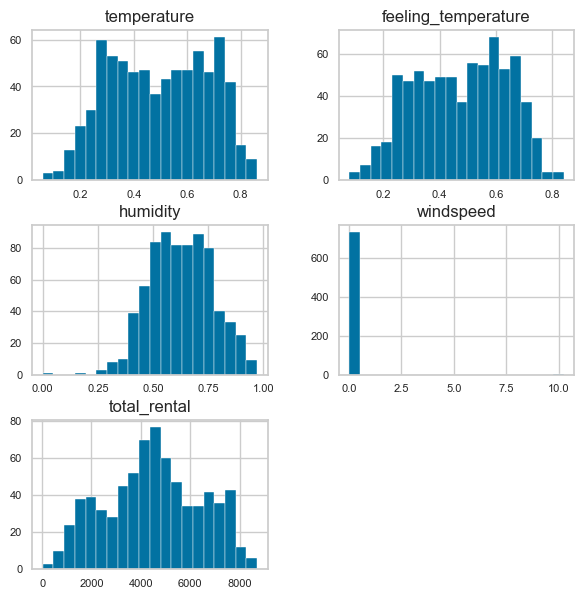

In [36]:
'''# Define numerical cols
numerical_cols = ['temperature',
                  'feeling_temperature',
                  'humidity',
                  'windspeed',
                  # 'casual',
                  #'registered',
                  'total_rental']'''

# Do histograms on all numeric variables
ds[numerical_cols].hist(bins=20, figsize=(7, 7), layout=(3, 2), xlabelsize=8, ylabelsize=8);

#### **Outliers detection**


Since some of the columns of the dataset is not normally distributed, percentiles will be calculated to check outliers.

Outliers in humidity: [0.187917 0.      ]
Outliers in windspeed: [ 0.417908  0.507463 10.234234  0.388067  0.422275  0.415429  0.409212
  0.421642  0.441563  0.4148    0.386821  0.398008  0.407346]


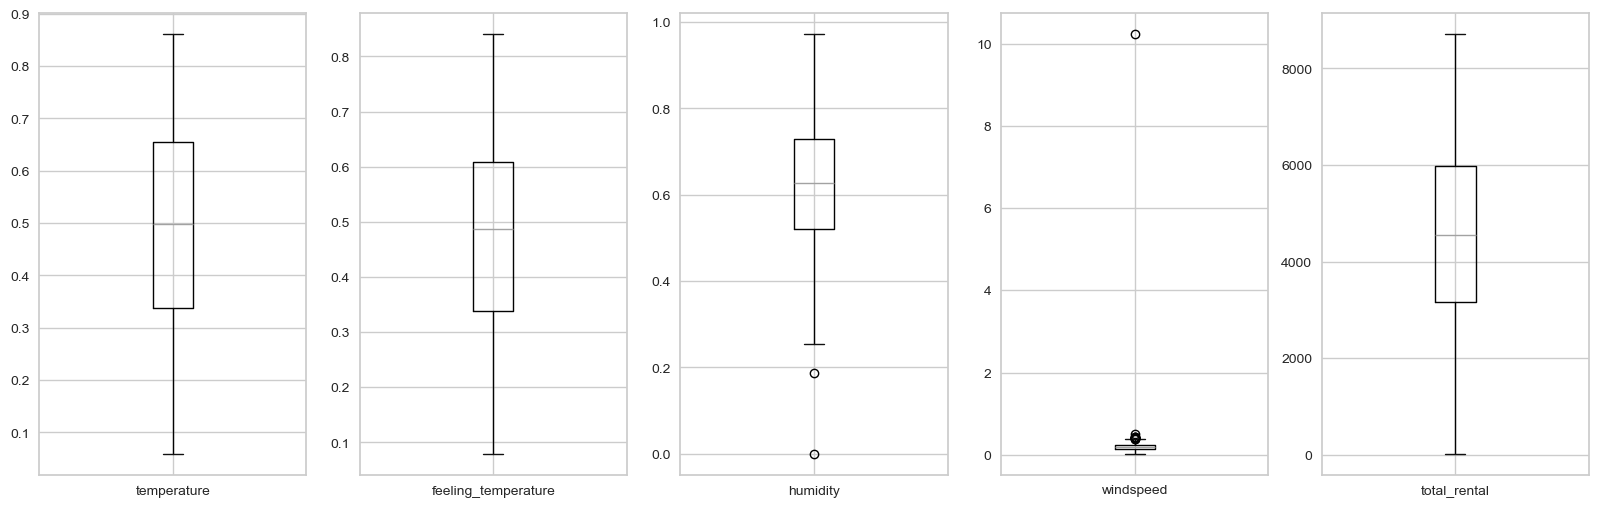

In [ ]:
outliers_ds = ds[numerical_cols]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,6))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    # Box plot
    outliers_ds.boxplot(column=col, ax=axes[i])

    # Calculating outliers
    Q1 = outliers_ds[col].quantile(0.25)
    Q3 = outliers_ds[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Finding outlier values
    outliers = outliers_ds[(outliers_ds[col] < lower_bound) | (outliers_ds[col] > upper_bound)][col]

    # Printing outlier values
    if not outliers.empty:
        print(f'Outliers in {col}: {outliers.values}')

for j in range(len(numerical_cols), len(axes)):
    axes[j].axis('off')

plt.show()

- 'hum' has 2 outliers.
- 'winspeed' has 13 outliers. While others stand very close to each other, one outlier looks extreme above 10.

Outliers will be removed with different combinations of quantile ranges, taking into account the performance of the models. 

In [ ]:
# View the rows, if the value of 'schoolday' column, excluding missing values, matches with 'workingday' column 
similar_values = ds[ds['schoolday'].isin(ds['workingday'])]
similar_values

,instant,date,season,year,month,day,holiday,weekday,workingday,schoolday,weather_condition,temperature,feeling_temperature,humidity,windspeed,casual,registered,total_rental
0,1,2011-01-01,Spring,2011,Jan,1,no,Saturday,no,no,Mist & Cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,Spring,2011,Jan,2,no,Sunday,no,no,Mist & Cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,Spring,2011,Jan,3,no,Monday,yes,yes,Clear & Few clouds,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,Spring,2011,Jan,4,no,Tuesday,yes,yes,Clear & Few clouds,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,Spring,2011,Jan,5,no,Wednesday,yes,yes,Clear & Few clouds,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,727,2012-12-27,Spring,2012,Dec,27,no,Thursday,yes,yes,Mist & Cloudy,0.254167,0.226642,0.652917,0.350133,247,1867,2114
728,728,2012-12-28,Spring,2012,Dec,28,no,Friday,yes,yes,Mist & Cloudy,0.253333,0.255046,0.590000,0.155471,644,2451,3095
729,729,2012-12-29,Spring,2012,Dec,29,no,Saturday,no,no,Mist & Cloudy,0.253333,0.242400,0.752917,0.124383,159,1182,1341
730,730,2012-12-30,Spring,2012,Dec,30,no,Sunday,no,no,Clear & Few clouds,0.255833,0.231700,0.483333,0.350754,364,1432,1796


454 rows matched.

In [ ]:
# Show the count of non-missing values in 'schoolday' to double check
ds.schoolday.notnull().sum()

454

In [ ]:
# Count of rows where weekday is weekend and schoolday is yes 
weekend_schoolday_yes_count = ds[(ds['weekday'].isin(['Saturday', 'Sunday'])) & (ds['schoolday'] == 'yes')].shape[0]

print("Weekend and Schoolday 'Yes':", weekend_schoolday_yes_count)

Weekend and Schoolday 'Yes': 0


- Before deciding whether to impute the 'schoolday' column, I wanted to explore its relationship with the 'workingday' column. Based on the analysis, I found that where 'working day' is 1, 'schoolday' is also consistently 1, and where 'working day' is 0, 'schoolday' is consistently 0. Therefore, since the values in the 'schoolday' column mirror those in the 'working day' column, it is concluded that the 'schoolday' column can be safely removed.

- Replacing missing values based on the 'weekday' column might seem like a good idea, but looking at the data, it's clear this won't give us any new useful information for the models. It's because when it's a weekday, 'schoolday' is marked 'yes', and on weekends, it's 'no'. This is basically the same as what we already know from the 'workingday' column.

## **3. DATA PREPARATION**

- Drop unnecessary columns('instant', 'date', 'casual', 'registered', 'schoolday')
- Remove the duplicated row
- Impute missing values for 'weekday' column
- 'feeling_temperature' column which is 0.99 correlated with the "temp" column, It will be dropped
- Remove outliers

In [ ]:
# Create a modeling dataset from the original dataset to prevent data leakage. Apply data cleaning and preprocessing on the copied version
# Since the dataset is small and memory usage is not a concern, deep copy is applied
X = ds.copy(deep=True)
print(X.columns)

Index(['instant', 'date', 'season', 'year', 'month', 'day', 'holiday',
       'weekday', 'workingday', 'schoolday', 'weather_condition',
       'temperature', 'feeling_temperature', 'humidity', 'windspeed', 'casual',
       'registered', 'total_rental'],
      dtype='object')


#### **Drop unnecessary columns**

In [ ]:
X = X.drop(['instant', 'date', 'casual', 'registered', 'schoolday'], axis=1)
print(X.columns)

Index(['season', 'year', 'month', 'day', 'holiday', 'weekday', 'workingday',
       'weather_condition', 'temperature', 'feeling_temperature', 'humidity',
       'windspeed', 'total_rental'],
      dtype='object')


Dropped finely.

#### **Drop the duplicated row**

In [ ]:
# Drop the duplicate rows 
X = X.drop_duplicates()

# Print number of the duplicated rows after the dropping
X.duplicated().sum()

0

Number of duplicated rows are 0. 

In [ ]:
# Check the number of rows
X.shape

(731, 13)

Total rows dropped from 732 to 731. Done successfully.

#### **Handling missing values in the 'weekday' column**

In [ ]:
# Check the counts of values to decide imputation method
X['weekday'].value_counts()

weekday
Monday       105
Saturday     105
Sunday       104
Thursday     104
Tuesday      104
Wednesday    104
Friday       103
Name: count, dtype: int64

The most frequent values in the dataset for the 'weekday' column is Monday, followed by Saturday.

In [ ]:
# Find the indices of missing values
missing_indices = X.index[X['weekday'].isna()].tolist()

# Replace one missing value with 'Saturday' and the other with 'Monday'
X.loc[missing_indices[0], 'weekday'] = 'Saturday'
X.loc[missing_indices[1], 'weekday'] = 'Monday'

X['weekday'].value_counts()

weekday
Monday       106
Saturday     106
Sunday       104
Thursday     104
Tuesday      104
Wednesday    104
Friday       103
Name: count, dtype: int64

Since there are two missing values, I assigned one for Monday and one for Saturday (corresponding mode values).

#### **Filtering the outliers**

In [ ]:
for col in numerical_cols:
    Q1, Q3 = X[col].quantile([0.15, 0.85]) # 10-90, 5-95, 15-85(best) 
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)].index

    # Drop outliers
    X.drop(outliers, inplace=True)

I noticed that outliers for different quantile ranges give different results. For that, I decided to choose the range (15-85) that gives better training and test results. 

In [ ]:
print(X.shape)

(728, 13)


With the range 0.15-0.85, 3 rows removed. 

#### **Encoding**

In [ ]:
# Perform one-hot encoding
cols = ['season', 'year', 'month','weather_condition', 'weekday', 'holiday', 'workingday']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

Since the decision tree models don't assume any ordinal relationship between categories, One hot encoding is applied. For Lasso Regression that can benefit from ordinal information or have assumptions about the ordinality of features, OrdinalEncoder is applied. 
Since the results are not affected by encoding type for Lasso Regression, I used only One Hot Encoding. 

In [ ]:
# Check the encoded variables
print(X.columns)
X.head()

Index(['season_Spring', 'season_Summer', 'season_Fall', 'season_Winter',
       'year_2011.0', 'year_2012.0', 'month_Jan', 'month_Feb', 'month_Mar',
       'month_Apr', 'month_May', 'month_Jun', 'month_Jul', 'month_Aug',
       'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec', 'day', 'holiday_no',
       'holiday_yes', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday',
       'weekday_Friday', 'workingday_no', 'workingday_yes',
       'weather_condition_Mist & Cloudy',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature',
       'feeling_temperature', 'humidity', 'windspeed', 'total_rental'],
      dtype='object')


,season_Spring,season_Summer,season_Fall,season_Winter,year_2011.0,year_2012.0,month_Jan,month_Feb,month_Mar,month_Apr,...,workingday_no,workingday_yes,weather_condition_Mist & Cloudy,weather_condition_Clear & Few clouds,weather_condition_Light snow & Rain,temperature,feeling_temperature,humidity,windspeed,total_rental
0,1,0,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0.344167,0.363625,0.805833,0.160446,985
1,1,0,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0.363478,0.353739,0.696087,0.248539,801
2,1,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0.226957,0.229270,0.436957,0.186900,1600


All looks fine.

#### **Correlation matrix**

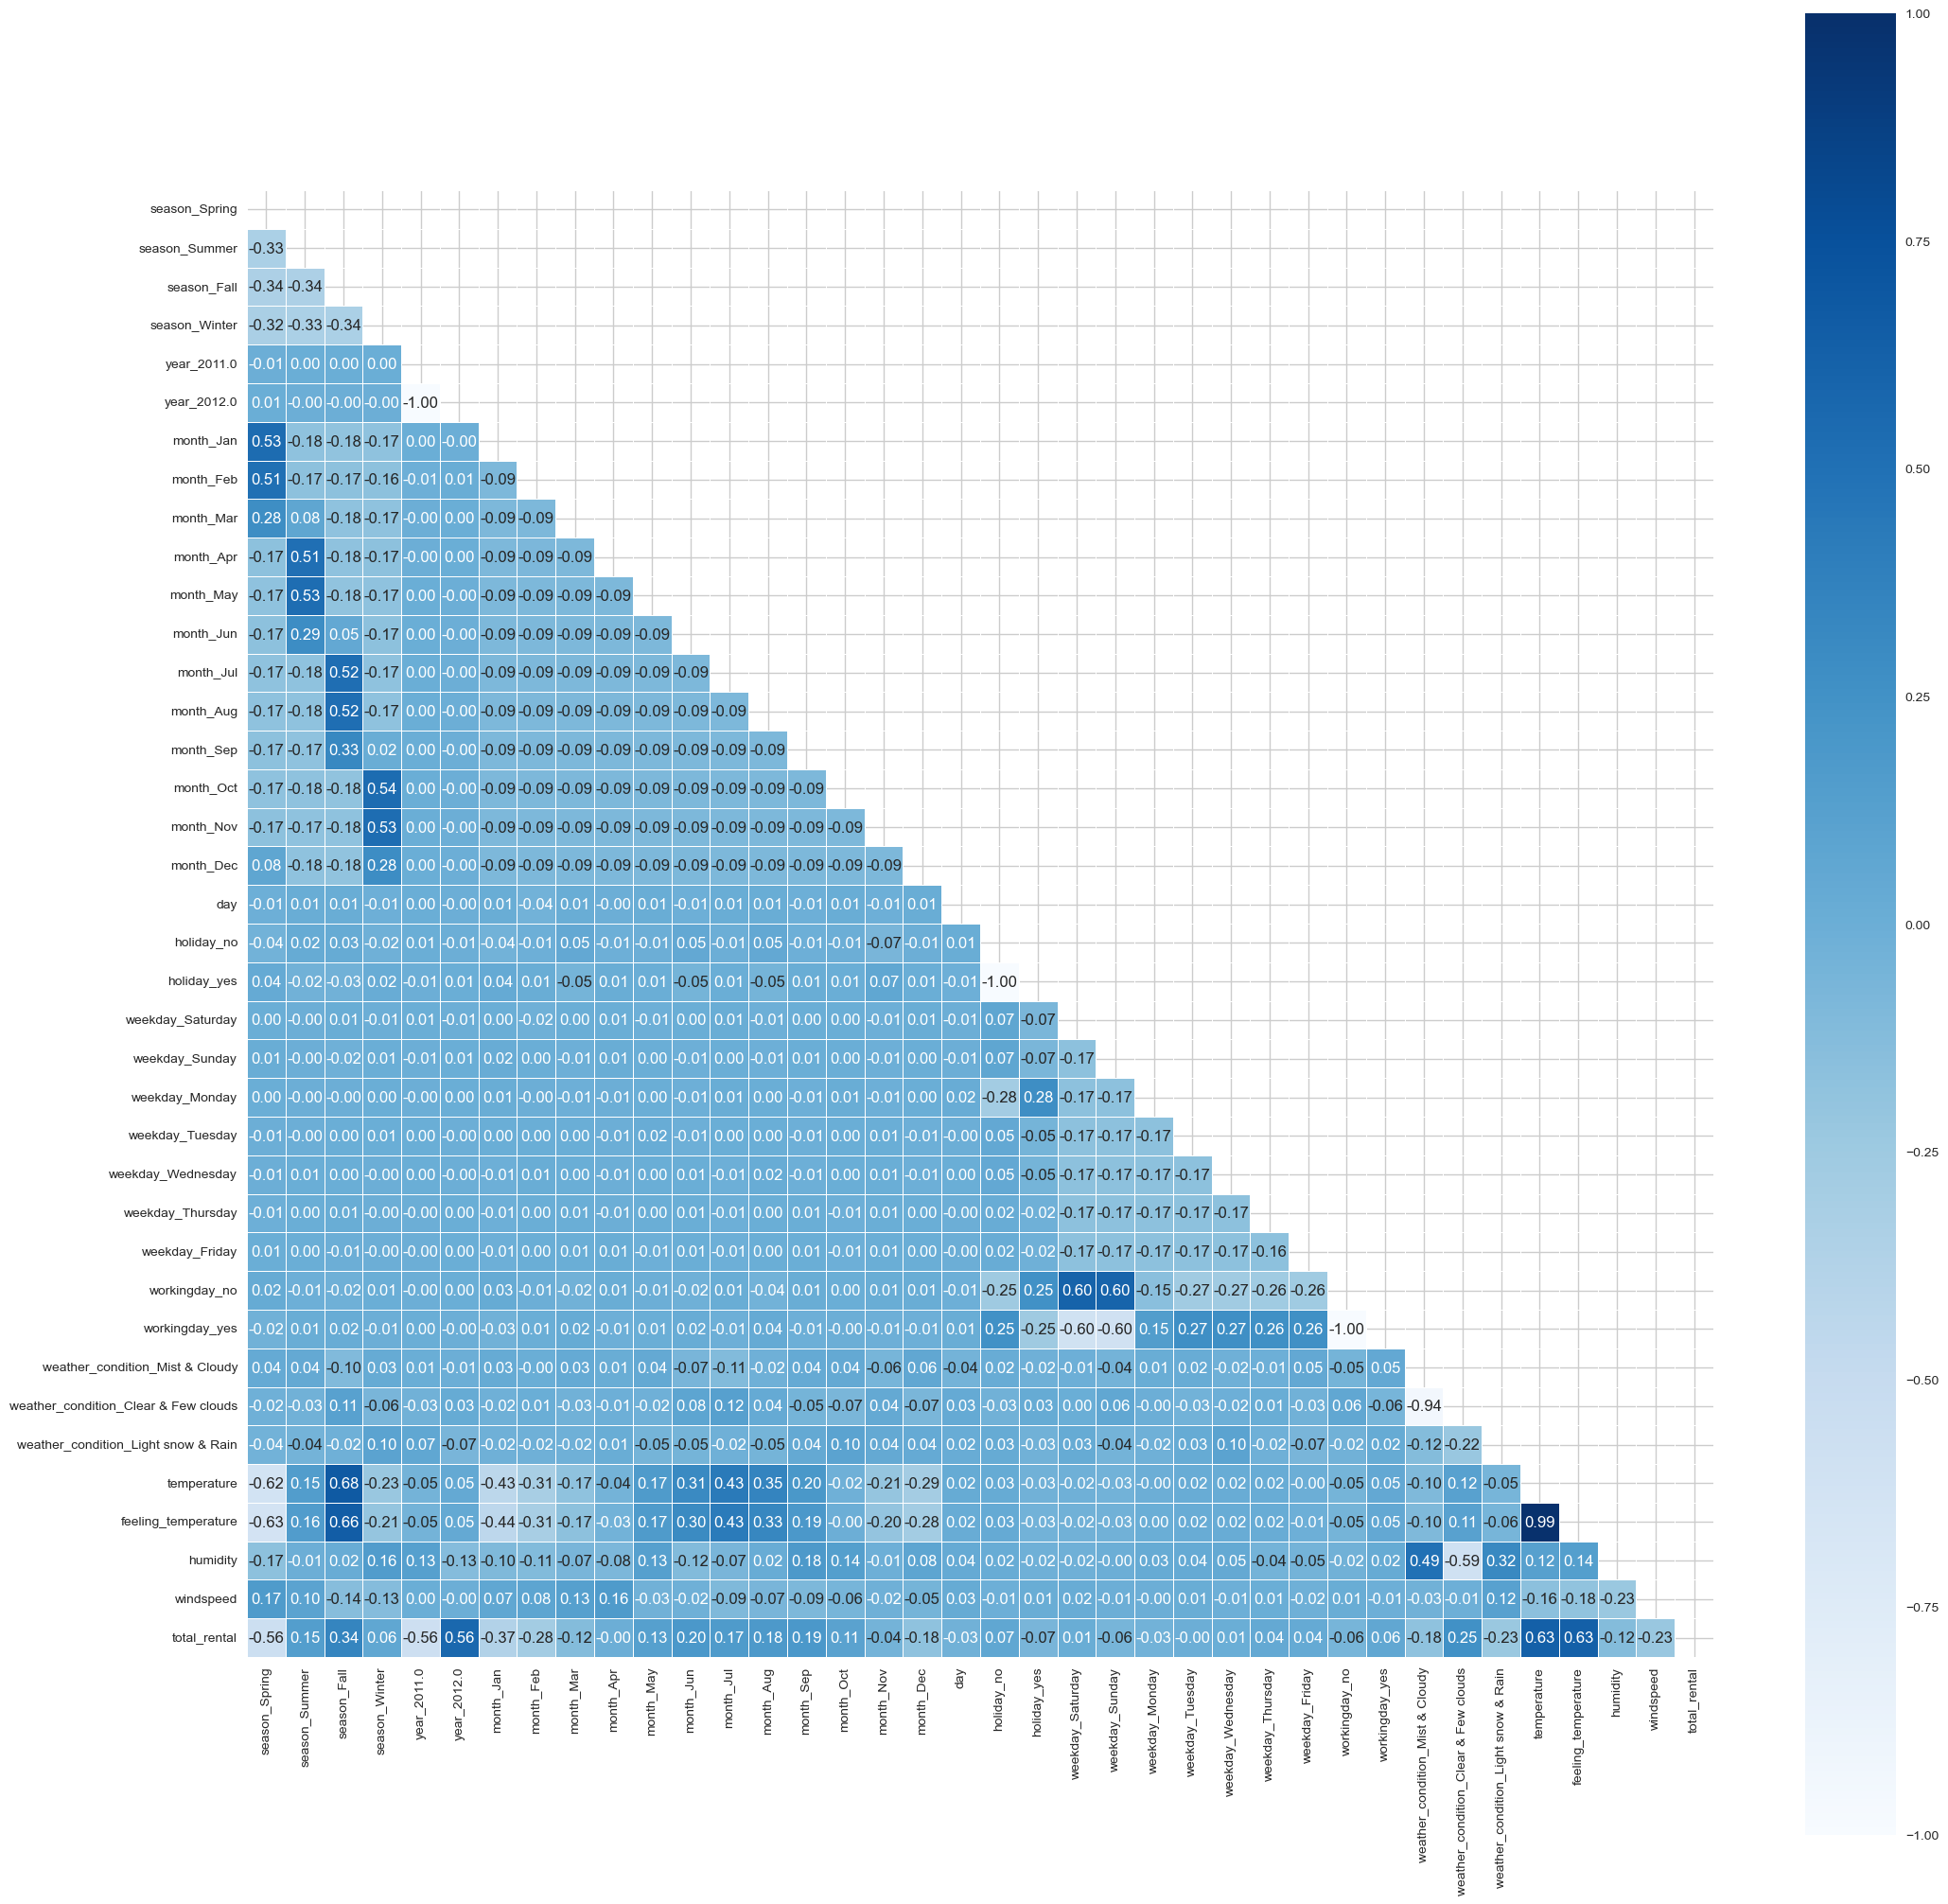

In [ ]:
# Calculate correlation matrix
correlation_matrix = X.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the size of the figure
plt.figure(figsize=(25, 25))

# Plot the heatmap
sns.heatmap(correlation_matrix, cmap='Blues', mask=mask,
                square=True,
                linewidths=.5,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt=".2f")
plt.show()

The 'temperature' and 'feeling temperature' are correlated with 0.99 as we observed in the beginning. The “feeling temperature” is an indicator that includes air temperature, humidity and wind speed. We have 'humidity' and ' 'windspeed' columns already. we decided to drop 'feeling_temperature'.

In [ ]:
X = X.drop(['feeling_temperature'], axis=1)
print(X.columns)

Index(['season_Spring', 'season_Summer', 'season_Fall', 'season_Winter',
       'year_2011.0', 'year_2012.0', 'month_Jan', 'month_Feb', 'month_Mar',
       'month_Apr', 'month_May', 'month_Jun', 'month_Jul', 'month_Aug',
       'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec', 'day', 'holiday_no',
       'holiday_yes', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday',
       'weekday_Friday', 'workingday_no', 'workingday_yes',
       'weather_condition_Mist & Cloudy',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature', 'humidity',
       'windspeed', 'total_rental'],
      dtype='object')


#### **Feature engineering**

In [ ]:
# Check the percentiles for columns to create bins for 'temperature', 'humidity', 'windspeed' columns
X[['temperature', 'humidity', 'windspeed']].describe()

,temperature,humidity,windspeed
count,728.000000,728.000000,728.000000
mean,0.495556,0.629638,0.189685
std,0.183328,0.139650,0.076371
min,0.059130,0.254167,0.022392
25%,0.336458,0.522396,0.134798
50%,0.499167,0.628333,0.180348
75%,0.655833,0.730625,0.233028
max,0.861667,0.972500,0.441563


In [ ]:
# Define label and bins based on the percentiles
temperature_bins = [0, 0.34, 0.5, 1.0]
temperature_labels = ['Cold', 'Moderate', 'Hot']
temperature_category = pd.cut(X['temperature'], bins=temperature_bins, labels=temperature_labels)
X['temperature_category'] = temperature_category

humidity_bin_edges = [-1, 0.52, 0.63, 1.0]
humidity_bin_labels = ['Low', 'Moderate', 'High']
humidity_category = pd.cut(X['humidity'], bins=humidity_bin_edges, labels=humidity_bin_labels)
X['humidity_category'] = humidity_category

wind_bin_edges = [-1, 0.13, 0.18, 1.0]
wind_bin_labels = ['Low', 'Moderate', 'High']
wind_speed_category = pd.cut(X['windspeed'], bins=wind_bin_edges, labels=wind_bin_labels, include_lowest=True)
X['wind_speed_category'] = wind_speed_category

# Drop the original columns
X.drop(columns=['temperature', 'humidity', 'windspeed'], inplace=True)

In [ ]:
# Check unique values to confirm
print(X['temperature_category'].unique())
print(X['humidity_category'].unique())
print(X['wind_speed_category'].unique())

['Moderate', 'Cold', 'Hot']
Categories (3, object): ['Cold' < 'Moderate' < 'Hot']
['High', 'Low', 'Moderate']
Categories (3, object): ['Low' < 'Moderate' < 'High']
['Moderate', 'High', 'Low']
Categories (3, object): ['Low' < 'Moderate' < 'High']


Unique values are the ones I assigned to the bins. Good!

In [ ]:
# Encode new categorical values into dummy variables
cols = ['temperature_category', 'humidity_category', 'wind_speed_category']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [ ]:
# Confirm
X.tail()

,season_Spring,season_Summer,season_Fall,season_Winter,year_2011.0,year_2012.0,month_Jan,month_Feb,month_Mar,month_Apr,...,total_rental,temperature_category_Cold,temperature_category_Moderate,temperature_category_Hot,humidity_category_Low,humidity_category_Moderate,humidity_category_High,wind_speed_category_Low,wind_speed_category_Moderate,wind_speed_category_High
727,1,0,0,0,0,1,0,0,0,0,...,2114,1,0,0,0,0,1,0,0,1
728,1,0,0,0,0,1,0,0,0,0,...,3095,1,0,0,0,1,0,0,1,0
729,1,0,0,0,0,1,0,0,0,0,...,1341,1,0,0,0,0,1,1,0,0
730,1,0,0,0,0,1,0,0,0,0,...,1796,1,0,0,1,0,0,0,0,1
731,1,0,0,0,0,1,0,0,0,0,...,2729,1,0,0,0,1,0,0,1,0


In [ ]:
# Summary statistics for all variables after data preparation - Transpose
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
season_Spring,728.0,0.245879,0.430903,0.0,0.0,0.0,0.0,1.0
season_Summer,728.0,0.251374,0.434101,0.0,0.0,0.0,1.0,1.0
season_Fall,728.0,0.258242,0.437969,0.0,0.0,0.0,1.0,1.0
season_Winter,728.0,0.244505,0.430089,0.0,0.0,0.0,0.0,1.0
year_2011.0,728.0,0.497253,0.500336,0.0,0.0,0.0,1.0,1.0
year_2012.0,728.0,0.502747,0.500336,0.0,0.0,1.0,1.0,1.0
month_Jan,728.0,0.085165,0.279319,0.0,0.0,0.0,0.0,1.0
month_Feb,728.0,0.076923,0.266653,0.0,0.0,0.0,0.0,1.0
month_Mar,728.0,0.083791,0.277265,0.0,0.0,0.0,0.0,1.0
month_Apr,728.0,0.081044,0.273090,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Correlation matrix for target(total_rental) column after data preparation
correlation_matrix = X.corr()['total_rental'].sort_values(ascending=False)

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
total_rental                            1.000000
temperature_category_Hot                0.569912
year_2012.0                             0.564704
season_Fall                             0.344931
weather_condition_Clear & Few clouds    0.253227
month_Jun                               0.195079
month_Sep                               0.194171
month_Aug                               0.181543
month_Jul                               0.165624
season_Summer                           0.146168
month_May                               0.131824
wind_speed_category_Moderate            0.130109
wind_speed_category_Low                 0.118523
month_Oct                               0.108035
humidity_category_Moderate              0.105774
holiday_no                              0.069668
season_Winter                           0.062647
workingday_yes                          0.061115
weekday_Thursday                        0.040155
weekday_Friday                          0.035011


In [ ]:
# Create the target variable
y = X['total_rental']

In [ ]:
# Make sure target variable is correctly assigned
y

0       985
1       801
2      1349
3      1562
4      1600
       ... 
727    2114
728    3095
729    1341
730    1796
731    2729
Name: total_rental, Length: 728, dtype: int64

In [ ]:
# Drop the target from the training data
X = X.drop(['total_rental'], axis=1)

In [ ]:
# Check X has all the columns in the dataset except 'total_rental' column
X.columns

Index(['season_Spring', 'season_Summer', 'season_Fall', 'season_Winter',
       'year_2011.0', 'year_2012.0', 'month_Jan', 'month_Feb', 'month_Mar',
       'month_Apr', 'month_May', 'month_Jun', 'month_Jul', 'month_Aug',
       'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec', 'day', 'holiday_no',
       'holiday_yes', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday',
       'weekday_Friday', 'workingday_no', 'workingday_yes',
       'weather_condition_Mist & Cloudy',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature_category_Cold',
       'temperature_category_Moderate', 'temperature_category_Hot',
       'humidity_category_Low', 'humidity_category_Moderate',
       'humidity_category_High', 'wind_speed_category_Low',
       'wind_speed_category_Moderate', 'wind_speed_category_High'],
      dtype='object')

In [ ]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=random_state) 

In [ ]:
# Check shape of the splits to confirm
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (582, 42)
Shape of X_test: (146, 42)
Shape of y_train: (582,)
Shape of y_test: (146,)


## **4. MODELING**

### Random Forest Regressor

#### Hyperparameter Tuning - Optuna

In [ ]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators',50, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    # Create a RandomForest regressor with trial parameters
    rf_reg = RandomForestRegressor(random_state=random_state, **params)

    # Calculate cross-validated R-squared score using KFold
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    cv_score = cross_val_score(rf_reg, X_train, y_train, cv=cv, scoring='r2')
    score = cv_score.mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_rf = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_rf)
print("Best R-squared Score:", best_score)

[I 2024-04-28 11:15:06,065] A new study created in memory with name: no-name-0d425893-1c53-42a8-912d-a79c2fea569a
[I 2024-04-28 11:15:06,331] Trial 0 finished with value: 0.6891314953945284 and parameters: {'n_estimators': 58, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6891314953945284.
[I 2024-04-28 11:15:06,662] Trial 1 finished with value: 0.7022092649202711 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.7022092649202711.
[I 2024-04-28 11:15:07,070] Trial 2 finished with value: 0.7513145808860867 and parameters: {'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.7513145808860867.
[I 2024-04-28 11:15:07,324] Trial 3 finished with value: 0.6633524344580072 and parameters: {'n_estimators': 64, 'max_depth': 3, 'min_sampl

Best Parameters: {'n_estimators': 144, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best R-squared Score: 0.7839787031360537


In [ ]:
# Instantiate a RandomForestRegressor model with the best hyperparameters
rf_reg = RandomForestRegressor(**best_params_rf, random_state=random_state)

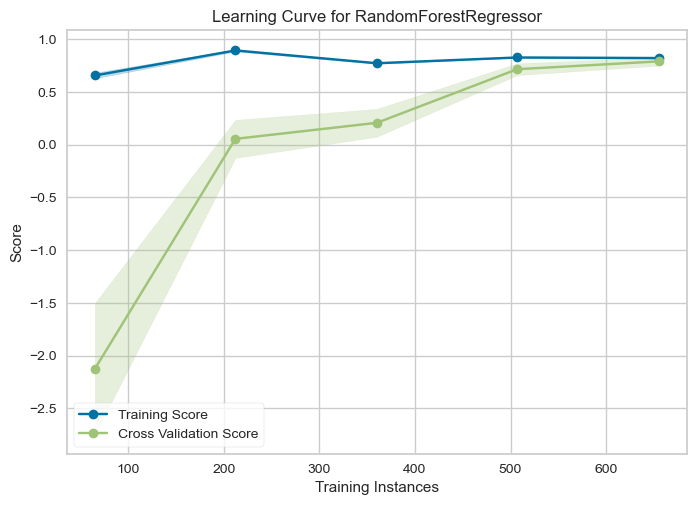

In [ ]:
# Plot the learning curve
plot_learning_curve(X, y, rf_reg)

https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

In [ ]:
# Fit the model to the training data
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=6,
                      n_estimators=144, random_state=2024)

In [ ]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in rf_reg.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in rf_reg.feature_importances_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
5,year_2012.0,0.169870,0.169870
0,season_Spring,0.148781,0.148781
4,year_2011.0,0.147987,0.147987
33,temperature_category_Cold,0.145345,0.145345
35,temperature_category_Hot,0.112644,0.112644
6,month_Jan,0.038269,0.038269
2,season_Fall,0.026786,0.026786
31,weather_condition_Clear & Few clouds,0.026215,0.026215
32,weather_condition_Light snow & Rain,0.017965,0.017965
34,temperature_category_Moderate,0.016133,0.016133


In [ ]:
# Evaluate RandomForestRegressor and compare train and test results
evaluate_model(rf_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0192 |       0.0192 |
+--------------------+---------------+--------------+
| MAE                |      608.1256 |     717.9874 |
+--------------------+---------------+--------------+
| RMSE               |      801.5965 |     914.9394 |
+--------------------+---------------+--------------+
| R^2                |        0.8265 |       0.7810 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.8130 |       0.6916 |
+--------------------+---------------+--------------+
| MAPE               |       50.1605 |      29.7014 |
+--------------------+---------------+--------------+
| Max Error          |     3800.8412 |    3278.7374 |
+--------------------+---------------+--------------+


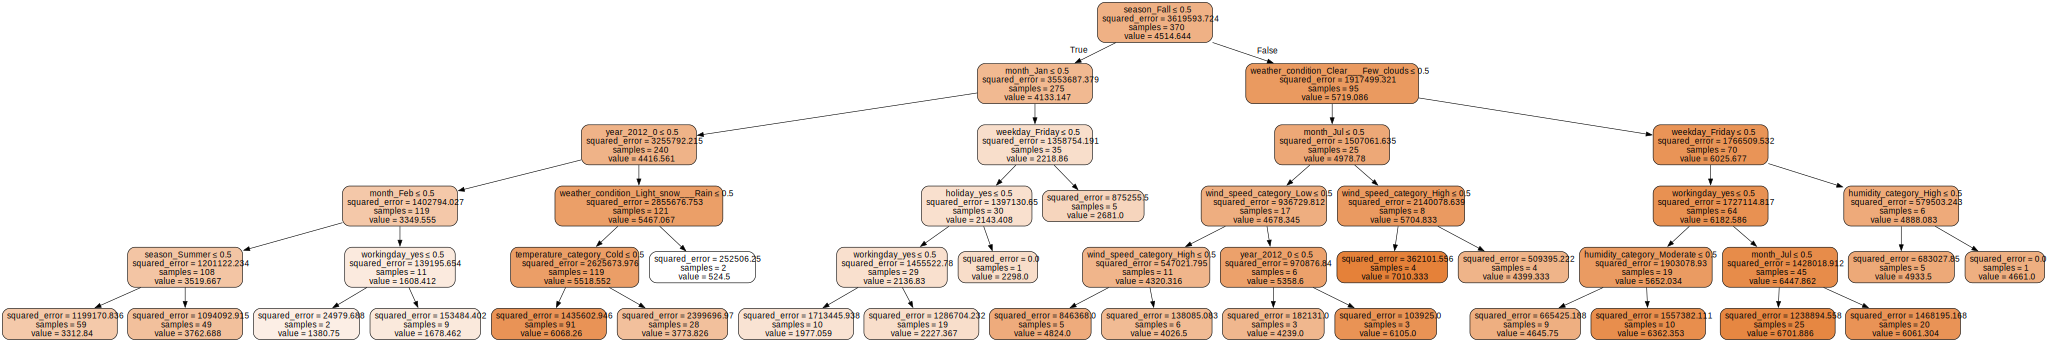

In [ ]:
# Accessing one of the decision trees from the random forest
tree_in_forest = rf_reg.estimators_[4]

# Export the decision tree to Graphviz format
dot_data = tree.export_graphviz(tree_in_forest, out_file=None,
                                feature_names=[re.sub('[^a-zA-Z0-9_]', '_', feature) for feature in X_train.columns],
                                filled=True, rounded=True,
                                special_characters=True)

# Visualize the decision tree
graph = graphviz.Source(dot_data)
# graph.render("random_forest_tree")  # Optionally save the tree to a file
# graph.view()  # View the tree in the default viewer
graph

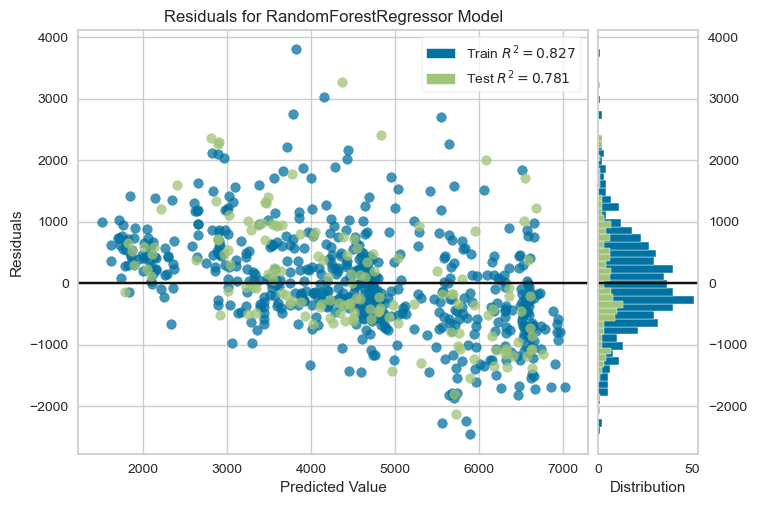

In [ ]:
# Visualize residuals 
visualize_residuals(rf_reg, X_train, y_train, X_test, y_test)

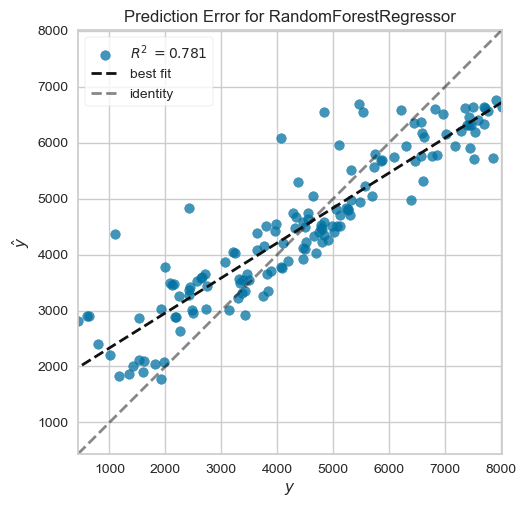

In [ ]:
# Prediction error plot
visualize_prediction_error(rf_reg, X_train, y_train, X_test, y_test)

### XGBoost Regressor

#### Hyperparameter Tuning - Optuna

In [ ]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [3, 6]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.75]),
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.03, 0.1]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [1, 10])
    }

    # Create an XGBoost regressor with trial parameters
    xg_reg = xgb.XGBRegressor(objective='reg:linear', random_state=random_state, **params)

    # Calculate cross-validated R-squared score
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    cv_score = cross_val_score(xg_reg, X_train, y_train, cv=cv, scoring='r2')
    score = cv_score.mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_xg = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_xg)
print("Best R-squared Score:", best_score)

[I 2024-04-28 11:15:39,774] A new study created in memory with name: no-name-3c813a75-e8ec-4a8d-8757-53607a5629de
[I 2024-04-28 11:15:40,421] Trial 0 finished with value: 0.8340706468241779 and parameters: {'max_depth': 3, 'subsample': 0.75, 'n_estimators': 50, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'reg_lambda': 10}. Best is trial 0 with value: 0.8340706468241779.
[I 2024-04-28 11:15:41,379] Trial 1 finished with value: 0.728629343396026 and parameters: {'max_depth': 6, 'subsample': 0.75, 'n_estimators': 50, 'colsample_bytree': 0.8, 'learning_rate': 0.03, 'reg_lambda': 10}. Best is trial 0 with value: 0.8340706468241779.
[I 2024-04-28 11:15:42,866] Trial 2 finished with value: 0.8471337558159613 and parameters: {'max_depth': 6, 'subsample': 0.75, 'n_estimators': 100, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'reg_lambda': 1}. Best is trial 2 with value: 0.8471337558159613.
[I 2024-04-28 11:15:43,832] Trial 3 finished with value: 0.84075569643164 and parameters: {'max_dept

Best Parameters: {'max_depth': 3, 'subsample': 0.75, 'n_estimators': 100, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'reg_lambda': 10}
Best R-squared Score: 0.8486741469467084


In [ ]:
# Instantiate a XGBoostRegressor model with the best hyperparameters
xg_reg = xgb.XGBRegressor(**best_params_xg, random_state=random_state)

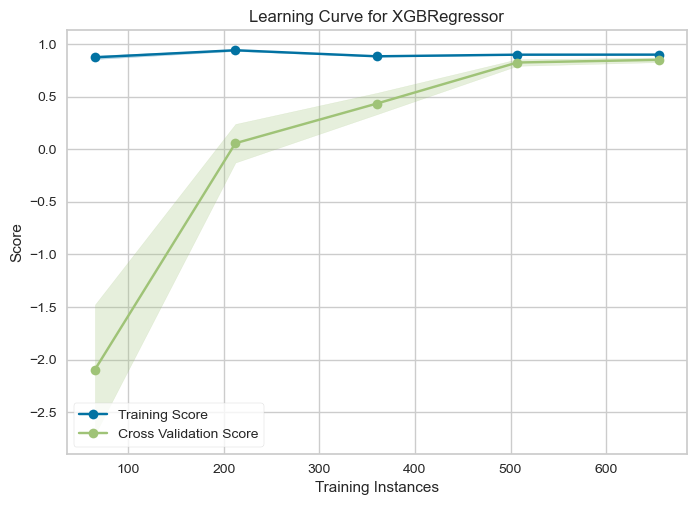

In [ ]:
# Plot the learning curve
plot_learning_curve(X, y, xg_reg)

In [ ]:
# Fit the model to the training data
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

In [ ]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in xg_reg.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in xg_reg.feature_importances_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
35,temperature_category_Hot,0.236187,0.236187
5,year_2012.0,0.148946,0.148946
33,temperature_category_Cold,0.143825,0.143825
0,season_Spring,0.114117,0.114117
4,year_2011.0,0.076630,0.076630
34,temperature_category_Moderate,0.034038,0.034038
3,season_Winter,0.032857,0.032857
31,weather_condition_Clear & Few clouds,0.027128,0.027128
32,weather_condition_Light snow & Rain,0.016251,0.016251
30,weather_condition_Mist & Cloudy,0.011927,0.011927


In [ ]:
# Evaluate XGBoost Regressor and compare train and test results
evaluate_model(xg_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0043 |       0.0043 |
+--------------------+---------------+--------------+
| MAE                |      424.8386 |     541.7708 |
+--------------------+---------------+--------------+
| RMSE               |      590.9385 |     747.0778 |
+--------------------+---------------+--------------+
| R^2                |        0.9057 |       0.8540 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.8984 |       0.7944 |
+--------------------+---------------+--------------+
| MAPE               |       33.1212 |      19.4800 |
+--------------------+---------------+--------------+
| Max Error          |     2704.7051 |    3623.8828 |
+--------------------+---------------+--------------+


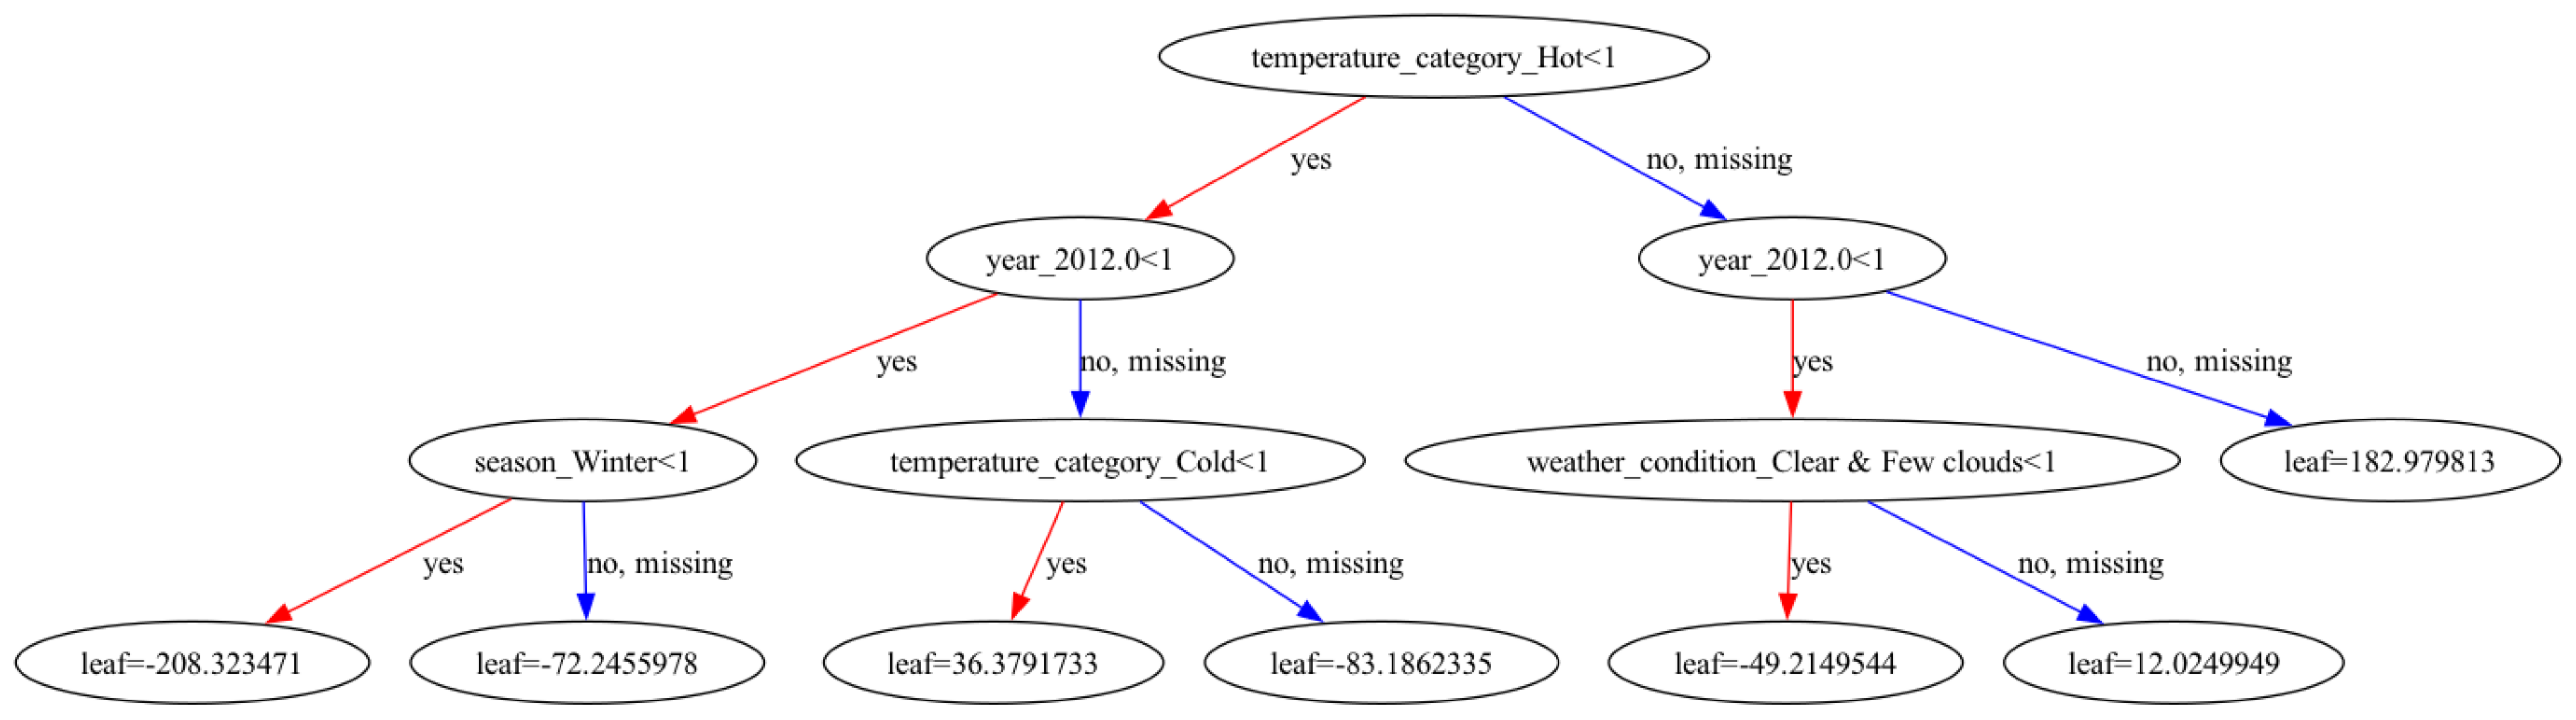

In [ ]:
# Visualize the first tree in the booster
xgb.plot_tree(xg_reg, num_trees=1)
plt.gcf().set_size_inches(50, 50)
plt.show()

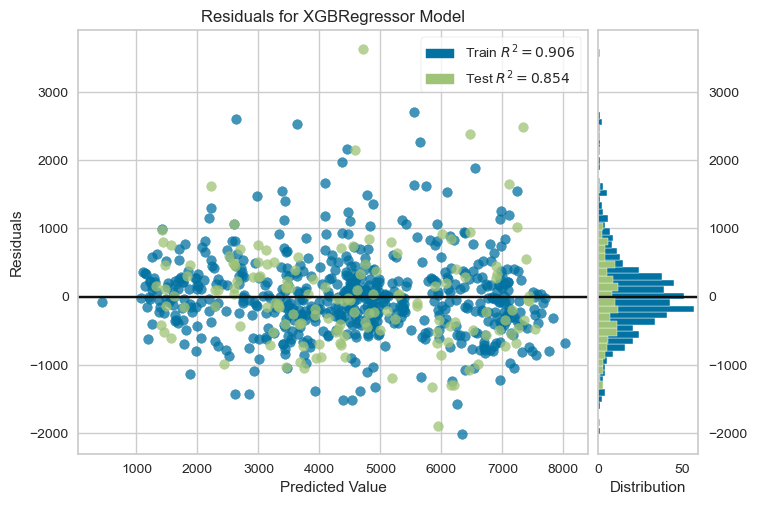

In [ ]:
# Visualize residuals 
visualize_residuals(xg_reg, X_train, y_train, X_test, y_test)

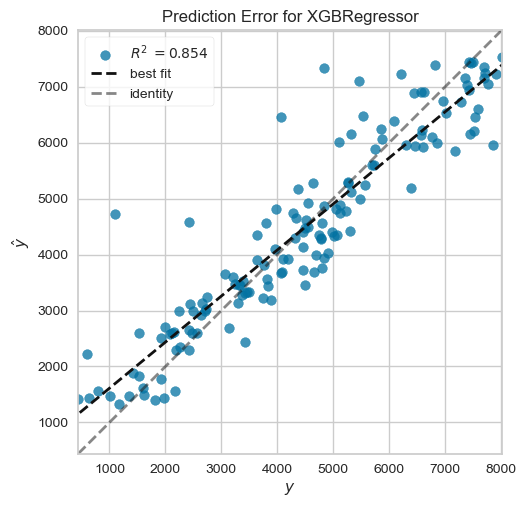

In [ ]:
# Prediction error plot
visualize_prediction_error(xg_reg, X_train, y_train, X_test, y_test)

### Gradient Boosting Regressor

#### Hyperparameter Tuning - Optuna

In [ ]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
    }

    # Create a GradientBoostingRegressor with trial parameters
    gb_reg = GradientBoostingRegressor(random_state=random_state, **params)

    # Calculate cross-validated R-squared score using KFold
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_score = cross_val_score(gb_reg, X_train, y_train, cv=cv, scoring='r2')
    score = cv_score.mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_gb = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_gb)
print("Best R-squared Score:", best_score)

[I 2024-04-28 11:16:16,593] A new study created in memory with name: no-name-c7a1b010-ab88-4f2e-958d-01a2a79aab9c
[I 2024-04-28 11:16:17,571] Trial 0 finished with value: 0.8094239160731883 and parameters: {'n_estimators': 86, 'max_depth': 9, 'learning_rate': 0.01965572644307131, 'subsample': 0.9112706180732513, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8094239160731883.
[I 2024-04-28 11:16:17,934] Trial 1 finished with value: 0.8188640968354047 and parameters: {'n_estimators': 53, 'max_depth': 5, 'learning_rate': 0.03334611389605321, 'subsample': 0.8342145129595018, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8188640968354047.
[I 2024-04-28 11:16:18,473] Trial 2 finished with value: 0.8406103469421314 and parameters: {'n_estimators': 97, 'max_depth': 5, 'learning_rate': 0.09490935769090696, 'subsample': 0.6152435659762281, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8406103469421314

Best Parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.07978053112739435, 'subsample': 0.9064475862487846, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best R-squared Score: 0.859519717211023


In [ ]:
# Instantiate a GradientBoostingRegressor model with the best hyperparameters
gb_reg = GradientBoostingRegressor(**best_params_gb, random_state=random_state)

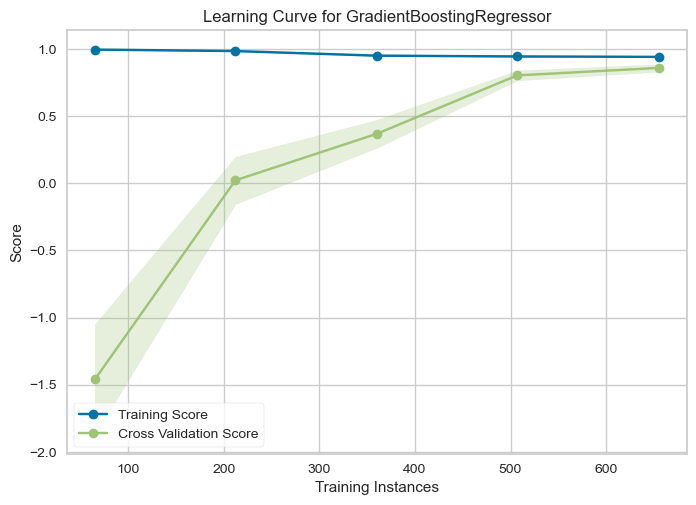

In [ ]:
# Plot the learning curve
plot_learning_curve(X, y, gb_reg)

In [ ]:
# Fit the model to the training data
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.07978053112739435, max_depth=4,
                          min_samples_split=4, n_estimators=83,
                          random_state=2024, subsample=0.9064475862487846)

In [ ]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in gb_reg.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in gb_reg.feature_importances_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
4,year_2011.0,0.187191,0.187191
0,season_Spring,0.186334,0.186334
33,temperature_category_Cold,0.182839,0.182839
5,year_2012.0,0.112618,0.112618
35,temperature_category_Hot,0.075606,0.075606
31,weather_condition_Clear & Few clouds,0.040942,0.040942
32,weather_condition_Light snow & Rain,0.033826,0.033826
3,season_Winter,0.027404,0.027404
18,day,0.026214,0.026214
34,temperature_category_Moderate,0.017397,0.017397


In [ ]:
# Evaluate GradientBoostingRegressor and compare train and test results
evaluate_model(gb_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0238 |       0.0238 |
+--------------------+---------------+--------------+
| MAE                |      321.5604 |     530.6300 |
+--------------------+---------------+--------------+
| RMSE               |      444.1825 |     738.7813 |
+--------------------+---------------+--------------+
| R^2                |        0.9467 |       0.8572 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.9426 |       0.7989 |
+--------------------+---------------+--------------+
| MAPE               |       12.7996 |      18.9122 |
+--------------------+---------------+--------------+
| Max Error          |     2154.5497 |    3876.4344 |
+--------------------+---------------+--------------+


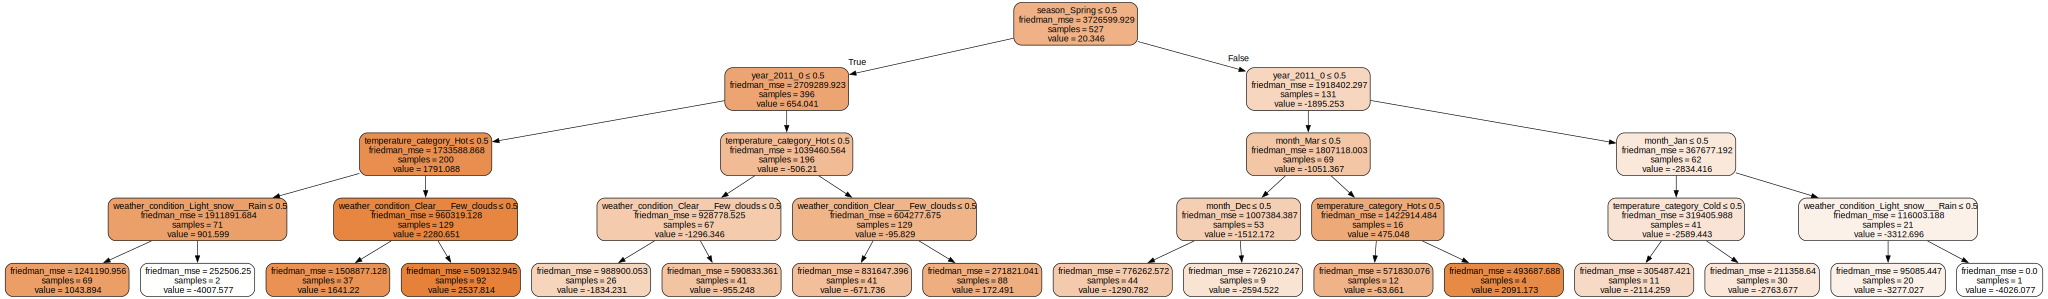

In [ ]:
# Accessing one of the decision trees from the gradient boosting regressor
tree_in_gb = gb_reg.estimators_[0][0]  # Accessing the first tree of the first estimator

# Export the decision tree to Graphviz format
dot_data = tree.export_graphviz(tree_in_gb, out_file=None,
                                feature_names=[re.sub('[^a-zA-Z0-9_]', '_', feature) for feature in X_train.columns],
                                filled=True, rounded=True,
                                special_characters=True)

# Visualize the decision tree
graph = graphviz.Source(dot_data)
# graph.render("gradient_boosting_tree")  # Optionally save the tree to a file
# graph.view()  # View the tree in the default viewer
graph

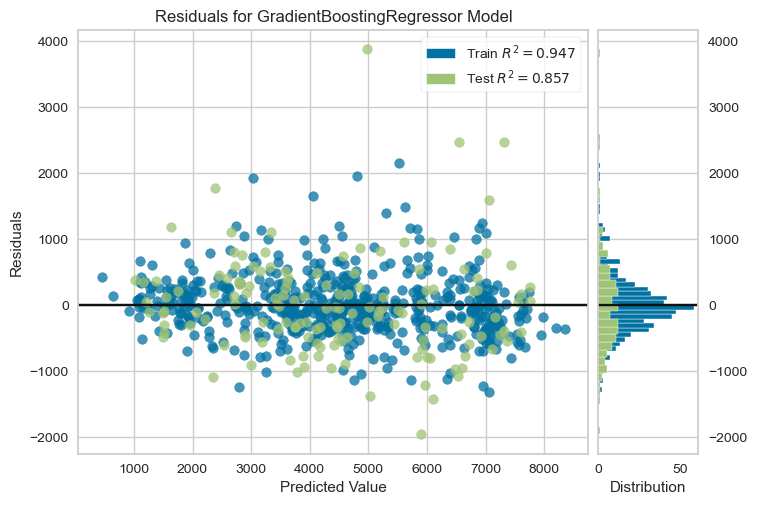

In [ ]:
# Visualize residuals
visualize_residuals(gb_reg, X_train, y_train, X_test, y_test)

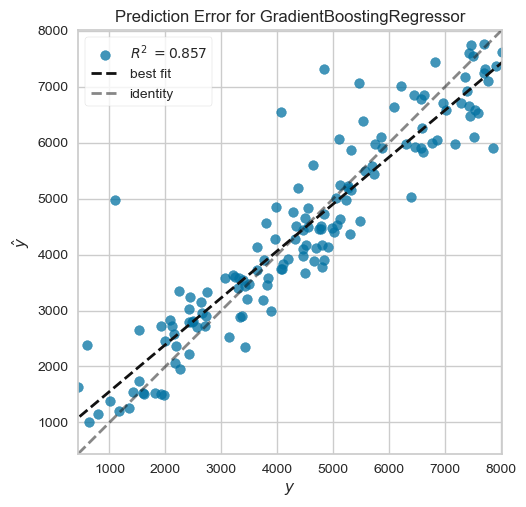

In [ ]:
# Prediction error plot
visualize_prediction_error(gb_reg, X_train, y_train, X_test, y_test)

### Lasso Regression

#### Hyperparameter Tuning - Optuna

In [ ]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'max_iter': trial.suggest_int('max_iter', 1000, 10000)
    }

    # Create a Lasso regressor with trial parameters
    lasso_reg = Lasso(random_state=random_state, **params)

    # Calculate cross-validated R-squared score using KFold
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    cv_score = cross_val_score(lasso_reg, X_train, y_train, cv=cv, scoring='r2')
    return cv_score.mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_lasso = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_lasso)
print("Best R-squared Score:", best_score)

[I 2024-04-28 11:16:48,935] A new study created in memory with name: no-name-42c15621-1cf4-425f-b1ea-4b0b9d369ac5
[I 2024-04-28 11:16:49,524] Trial 0 finished with value: 0.8257999222920805 and parameters: {'alpha': 0.05746788634960825, 'max_iter': 2063}. Best is trial 0 with value: 0.8257999222920805.
[I 2024-04-28 11:16:51,354] Trial 1 finished with value: 0.8257586839923323 and parameters: {'alpha': 0.009750048100776692, 'max_iter': 1161}. Best is trial 0 with value: 0.8257999222920805.
[I 2024-04-28 11:16:52,153] Trial 2 finished with value: 0.8258135506699192 and parameters: {'alpha': 0.0691337489161549, 'max_iter': 2610}. Best is trial 2 with value: 0.8258135506699192.
[I 2024-04-28 11:16:56,883] Trial 3 finished with value: 0.8257521968487168 and parameters: {'alpha': 0.004458104395163239, 'max_iter': 3558}. Best is trial 2 with value: 0.8258135506699192.
[I 2024-04-28 11:17:00,854] Trial 4 finished with value: 0.8257480607939325 and parameters: {'alpha': 0.0016332600271018072, 

Best Parameters: {'alpha': 0.6143215809912116, 'max_iter': 3086}
Best R-squared Score: 0.8261070792459659


In [ ]:
# Instantiate a Lasso model with the best hyperparameters
lasso_reg = Lasso(**best_params_lasso, random_state=random_state)

### Feature Selection - Recursive Feature Elimination

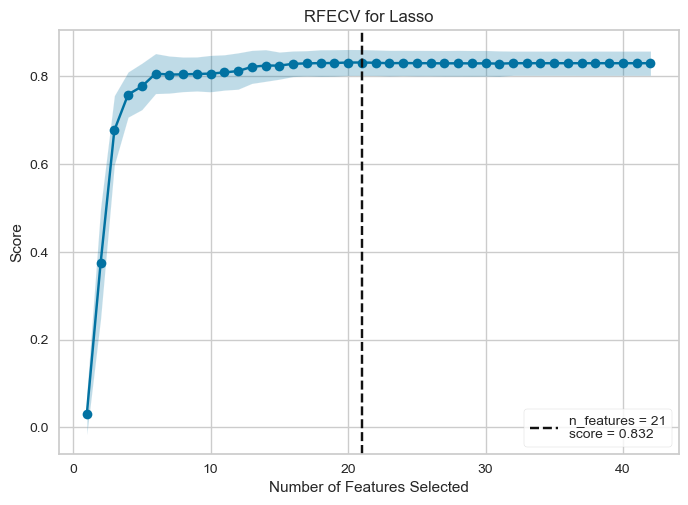

<Axes: title={'center': 'RFECV for Lasso'}, xlabel='Number of Features Selected', ylabel='Score'>

In [ ]:
# Recursive Feature Elimination with Cross Validation
vis = RFECV(lasso_reg, cv=cv, scoring='r2')
vis.fit(X_train, y_train)
vis.show()

In [ ]:
# Check supported columns
X.columns[vis.support_]

Index(['season_Spring', 'season_Summer', 'season_Winter', 'year_2011.0',
       'month_Jan', 'month_Feb', 'month_Apr', 'month_Jun', 'month_Sep',
       'month_Nov', 'month_Dec', 'holiday_no', 'weekday_Sunday',
       'weekday_Monday', 'weekday_Tuesday',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature_category_Cold',
       'temperature_category_Hot', 'humidity_category_High',
       'wind_speed_category_Low'],
      dtype='object')

In [ ]:
# Since the columns are one-hot encoded, standartization process is skipped
# Split the data into train and test only with supported columns by RFECV  
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, vis.support_], y, test_size=0.20, random_state=random_state)

In [ ]:
# Make sure train set does not contain target column
X_train.columns

Index(['season_Spring', 'season_Summer', 'season_Winter', 'year_2011.0',
       'month_Jan', 'month_Feb', 'month_Apr', 'month_Jun', 'month_Sep',
       'month_Nov', 'month_Dec', 'holiday_no', 'weekday_Sunday',
       'weekday_Monday', 'weekday_Tuesday',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature_category_Cold',
       'temperature_category_Hot', 'humidity_category_High',
       'wind_speed_category_Low'],
      dtype='object')

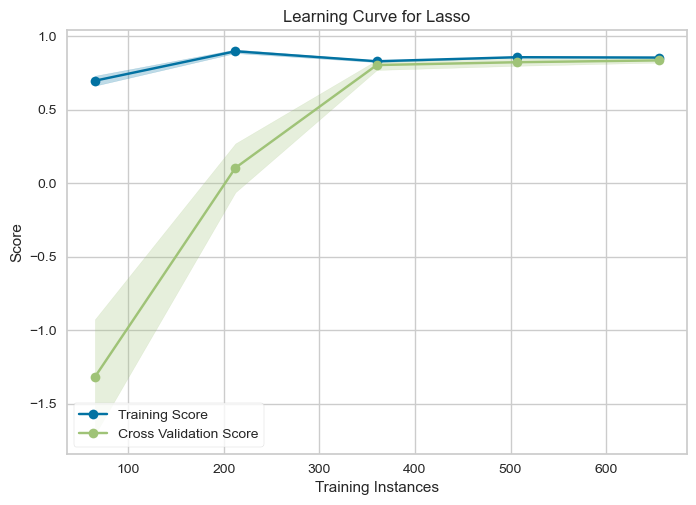

In [ ]:
# Plot the learning curve
plot_learning_curve(X, y, lasso_reg)

In [ ]:
# Fit the model to the training data
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.6143215809912116, max_iter=3086, random_state=2024)

In [ ]:
# Print the Intercept
print('Intercept:',lasso_reg.intercept_, '\n')

# Print Coefficients by descending "importance"
formattedList = [format(float(i),'.6f') for i in lasso_reg.coef_]
formattedList2 = [format(abs(float(i)),'.6f') for i in lasso_reg.coef_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df

Intercept: 5219.833540896676 



,Feature,Coefficient,AbsCoefficient
3,season_Winter,-2028.244807,2028.244807
16,month_Nov,-1801.695108,1801.695108
0,season_Spring,-1102.218743,1102.218743
17,month_Dec,-819.304290,819.304290
18,day,794.047992,794.047992
4,year_2011.0,-670.576768,670.576768
15,month_Oct,610.622866,610.622866
9,month_Apr,-568.823988,568.823988
10,month_May,-506.781635,506.781635
12,month_Jul,-496.310286,496.310286


In [ ]:
# Evaluate Lasso and compare train and test results
evaluate_model(lasso_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0125 |       0.0125 |
+--------------------+---------------+--------------+
| MAE                |      528.9589 |     562.3566 |
+--------------------+---------------+--------------+
| RMSE               |      739.6962 |     756.6260 |
+--------------------+---------------+--------------+
| R^2                |        0.8523 |       0.8502 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.8467 |       0.8248 |
+--------------------+---------------+--------------+
| MAPE               |       44.9652 |      18.8181 |
+--------------------+---------------+--------------+
| Max Error          |     3595.8393 |    3647.0773 |
+--------------------+---------------+--------------+


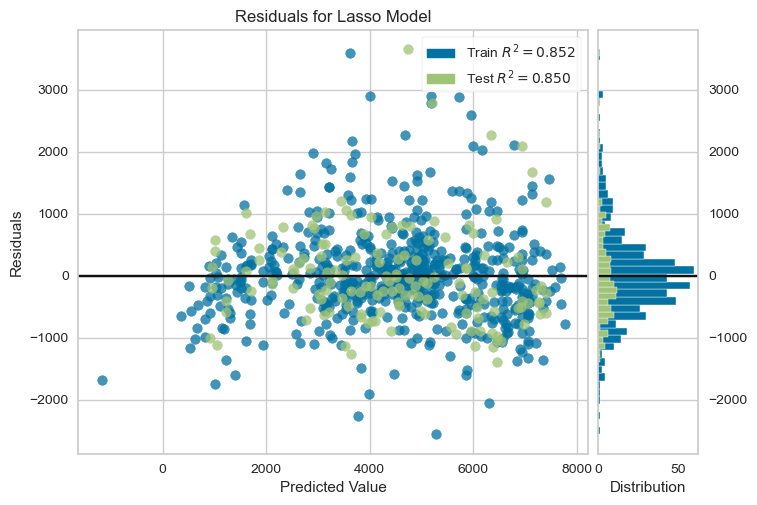

In [ ]:
# Visualize residuals 
visualize_residuals(lasso_reg, X_train, y_train, X_test, y_test)

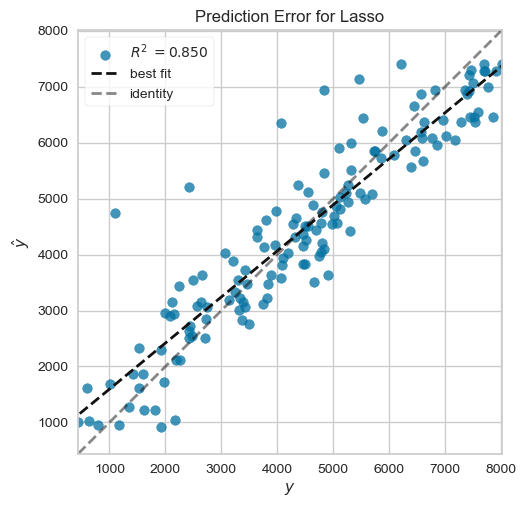

In [ ]:
# Prediction error plot
visualize_prediction_error(lasso_reg, X_train, y_train, X_test, y_test)

#### Save the best model 

In [ ]:
# Save the best model
file = open("model.pickle", "wb")
pickle.dump(lasso_reg, file)
file.close()